In [1]:
# imports
from collections import OrderedDict
import matplotlib.pyplot as plt
from astropy.time import Time
import os
import numpy as np
import math as m
from astropy import units as u
from astropy.table import Table
from astropy.time import Time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from cycler import cycler
import matplotlib.gridspec as gridspec # GRIDSPEC 
from scipy.optimize import curve_fit
from math import cos, pi,sqrt
from astropy.constants import G, c, M_sun
from astropy import units as u

In [4]:
def read_comp_diskbb(comp_file):
    data = np.genfromtxt(comp_file, delimiter='\t', names=True, dtype=("U23", "U13", "U14", "U11", 
                                                                       "<f8", "<f8", "<f8", 
                                                                       "<f8", "<f8", "<f8",
                                                                      "<f8", "<f8", "<f8"),
                        converters={10: logtoflux, 11: logtoflux_bounds, 12: logtoflux_bounds})

    if len(np.atleast_1d(data))>1:
        data.sort(order='epoch')
    return data


def read_pulsations_file(file):
    data = np.genfromtxt(file, delimiter='\t', names=True, dtype=("U23", "U13", "U14", "U11", 
                                                                       "i8", "<f8", "<f8"))
    if len(np.atleast_1d(data))>1:
        data.sort(order='epoch')
    return data

def read_tbabs(comp_file):
    data = np.genfromtxt(comp_file, delimiter='\t', names=True, dtype=("U23", "U11", "U14", "U10", 
                                                                       "<f8", "<f8", "<f8"), 
                         converters={5:linked_to_errors, 6:linked_to_errors})
    if len(np.atleast_1d(data))>1:
        data.sort(order='epoch')
    return data

def linked_to_errors(x):
    if float(x)==-3:
        return 0.0000001
    else:
        return x


def read_comp_cutoffpl(comp_file):
    data = np.genfromtxt(comp_file, delimiter='\t', names=True, 
                         dtype=("U23", "U13", "U7", "U14", "<f8", "<f8", "<f8", 
                                "<f8", "<f8", "<f8","<f8", "<f8", "<f8",
                               "<f8", "<f8", "<f8"), 
                         converters={13: logtoflux, 14: logtoflux_bounds, 
                                     15: logtoflux_bounds})
    data.sort(order='epoch')
    return data

def read_comp_compTT(comp_file):
    data = np.genfromtxt(comp_file, delimiter='\t', names=True, 
                         dtype=("U23", "U13", "U7", "U14", "<f8", "<f8", "<f8", 
                          "<f8", "<f8", "<f8", "<f8", "<f8", "<f8", "<f8", "<f8", "<f8",
                          "<f8", "<f8", "<f8", "<f8", "<f8", "<f8","<f8", "<f8", "<f8"), 
                         converters={22: logtoflux, 23: logtoflux_bounds, 
                                     24: logtoflux_bounds})
    data.sort(order='epoch')
    return data

def tojd (x):
    return Time(x).jd
     


def logtoflux_bounds(x):
    # keep upper and lower bounds to 0
    if float(x)==0:
        print("Flux bound found")
        return 0
    else:
        return m.pow(10,float(x))
    
def logtoflux(x):
    return m.pow(10,float(x))

def read_flux_data(flux_file):
    data = np.genfromtxt(flux_file, delimiter='\t', names=True, 
                         dtype=("U23", "U13", "U7", "<f8", "<f8", "<f8", "<f8", "<f8", "<f8", "<f8", 
                                "<f8", "<f8", "<f8", "<f8", "<f8", "<f8"), missing_values='Error',
                         converters={3: tojd, 4: logtoflux, 5: logtoflux_bounds, 6: logtoflux_bounds, 
                                    7: logtoflux, 8: logtoflux_bounds, 
                                   9: logtoflux_bounds, 10: logtoflux, 11: logtoflux_bounds, 12: logtoflux_bounds,
                                    13: logtoflux, 14: logtoflux_bounds, 15: logtoflux_bounds}, filling_values=0)
    data.sort(order='epoch')
    return data

def remove_legend_repetitions(ax):
    """Removes any repetead entries in the legend. Adds the legend to the plot too.
    Parameters
    ----------
    ax : The axis were the repeated entries are to be removed. """
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best', prop={'size': 20})

def bounds_to_errors(values, lowerbounds, upperbounds):
    ''' Compute errors given the lower and upper bounds of a an array of values.
    Parameters:
    -----------
    value : the central values given by the fit
    lowerbound : its lower bounds
    upperbound : its upper bounds'''

    lower_errors = values - lowerbounds
    upper_errors = upperbounds - values
    
    for value, lowerbound, upperbound in zip(values, lowerbounds, upperbounds):
        
        if upperbound<value and upperbound!=0:
            print("Warning upperbound is lower than value!!! %.5f < %.5f" % (upperbound, value))
        if lowerbound>value and lowerbound!=0:
            print("Warning lowerbound is higher than value!!! %.5f > %.5f" % (lowerbound, value))
            
    
    lolims = np.zeros(lower_errors.shape)
    # lower bound
    lolims[np.where(lowerbounds==0)] = 1
    values[np.where(lowerbounds==0)] = upperbounds[np.where(lowerbounds==0)]
    upper_errors[np.where(lowerbounds==0)] = values[np.where(lowerbounds==0)] / 10
    # upper bound
    uplims = np.zeros(lower_errors.shape)
    uplims[np.where(upperbounds==0)] = 1
    values[np.where(upperbounds==0)] = lowerbounds[np.where(upperbounds==0)]
    lower_errors[np.where(upperbounds==0)] = values[np.where(upperbounds==0)] / 10
    return lower_errors, upper_errors, lolims, uplims

def jd_to_daymonthyear(x, pos):
    '''Format the axis to convert from Julian day to real date.'''
    time = Time(x, format='jd')
    time.format = 'iso'
    time.out_subfmt = 'date'
    return time

def compute_ratios(hard_flux, hard_flux_low, hard_flux_high, soft_flux, soft_flux_low, soft_flux_high):
    """Compute hardness ratios given fluxes in two energy bands."""
    ratio = hard_flux / soft_flux
    soft_err_low = soft_flux - soft_flux_low
    soft_err_high = soft_flux_high - soft_flux
    hard_err_low = hard_flux - hard_flux_low
    hard_err_high = hard_flux_high - hard_flux
    ratio_err_low = ((hard_err_low / soft_flux)**2 + (hard_flux * soft_err_low / soft_flux**2)**2)**(1 / 2)
    ratio_err_high = ((hard_err_high / soft_flux)**2 + (hard_flux * soft_err_high / soft_flux**2)**2)**(1 / 2)
    return ratio, ratio_err_low, ratio_err_high


def create_color_array(data_length, cmap='hsv'):
    """Create an array of colors given the length of a dataset. Useful for plots where a unique color is needed for each dataset.

    The returned colors come from the input map (jet by default).

    Parameters
    ----------
    data_length : The length of your data for the color array creation.

    """
    print("Creating color array for %i datasets" % data_length)
    x = np.arange(data_length)
    ys = [i + x + (i * x)**2 for i in range(data_length)]
    setmap = plt.get_cmap(name=cmap)

    colors = setmap(np.linspace(0, 1, len(ys)))
    return colors


def get_markers_array(data_length):
    """Get an array of markers given the length of a dataset. Useful for plots where a unique marker is needed for each dataset.

    There are 17 different markers and after that they are repeated.

    Parameters
    ----------
    data_length : The length of your data for the marker array creation.

    """
    m = ['o', 'v', '^', "_", "1", 's', 'p', 'P', 'd', '*', 'h', '+', 'X', 'D', '8' , '>', 
         '<', 'x', '.', (10, 1, 20)]

    while data_length > len(m):
        m.extend(m)

    return m

def draw_arrows(x, y, colors):
    for i in np.arange(1, len(x)):
        plt.annotate("", xy=(x[i-1],y[i-1]), xytext=(x[i], y[i]),
        arrowprops=dict(arrowstyle="<-", shrinkA=10, shrinkB=10, color=colors[i-1]))
def fit_diskbb(fluxes, temperatures, temperatures_errlow, temperatures_errhigh):
    popt, pconv=curve_fit(diskLvsT, temperatures, fluxes,  
                          sigma=(temperatures_errlow + temperatures_errhigh)/2, 
                          p0=[10**-13,4])
    a, b = popt
    a_err, b_err = np.sqrt(np.diag(pconv))
    return a, b, a_err, b_err
 
    return

def diskLvsT(x, a, b):
            return a * x**b
    
def disknorm_tomass(norm, distance, angle=60):
    angle_rad = 60/360*2*pi
    #mega parsecs to parsecs
    distance = distance * 10**3 
    r_in = sqrt(norm/cos(angle_rad)) * (distance / (10)) * u.km
    M = r_in * (c.to("km/s")) ** 2 / 2 / G.to("km**3/kg/s**2") / M_sun
    return M
    
def plotdisk(data, ax, param_1="Tin", param_2="flux"):
    if len(np.atleast_1d(data))>1:
        colors = create_color_array(len(data["epoch"]), "jet")
        markers = get_markers_array(len(data["epoch"]))
    else:
        colors = ["cyan"]
        markers = ['x']
    ax.set_prop_cycle(cycler('color', colors))
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                         data["%slow" %param_1], 
                                                                                         data["%supp" %param_1])
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                         data["%slow" %param_2], 
                                                                                         data["%supp" %param_2])
    for index in np.arange(0, len(data["epoch"])):
        if data["xmm_obsid"][index]!="":
            label=data["xmm_obsid"][index]
        else:
            label=data["chandra"][index]

        ax.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , 
                             xerr=[[param_1err_low[index]], [param_1err_high[index]]], 
                             yerr=[[param_2err_low[index]], [param_2err_high[index]]], label=label, 
                             marker="$ f $", xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                             uplims=param_2uplimits[index], lolims=param_2lolimits[index], markersize=10)
def eddington_limit(M):
    return 1.26 * M * 10**38 / 10**39
def bolometric_l(M, m_dot):
    return eddington_limit(M) * (1 + 3/5 * np.log(m_dot))
def t_disk_max(M, m_dot):
    return 1.6 * (M)**(-1/4) * (1 - 0.2 * m_dot**(-1/3))
def t_spherization_max(M, m_dot):
    return 1.5 * (M)**(-1/4) * m_dot**(-1/2) * (1 + 0.3 * m_dot**(-3/4))
    

In [5]:
def readbroadbandfile(file="broadband_fitting_plot.config"):
    broadband_file = "/home/agurpide/x_ray_data/%s" %file
    plot_config = np.genfromtxt(broadband_file, delimiter="\t\t", dtype=("U13", "U17", "U18", float), names=True)
    print(plot_config.dtype)
    return plot_config

## Ratio (2-5)/(0.3-2) vs L (5-10)

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label in zip(plot_config["source_dir"], plot_config["source_name"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "M51-ULX7" in source:
        print(data)
    
    
    ratio, ratio_err_low, ratio_err_high = compute_ratios(constant * data["2050"], 
                                                          constant * data["lowerbound_1"], 
                                                          constant * data["upperbound_1"],
                                                          constant * data["0320"], 
                                                          constant * data["lowerbound"], 
                                                      constant * data["upperbound"])
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
    plt.errorbar(constant * data["50100"], ratio , xerr=[constant * (data["50100"]-data["lowerbound_2"]), constant * (data["upperbound_2"]-data["50100"])], yerr=[ratio_err_low, ratio_err_high], label=source_label, fmt=marker)
plt.xlabel("L [5 - 10 keV] (10$^{39}$) erg/s")
plt.ylabel("L [2 - 5 keV] / L [0.3 - 2 keV]")
plt.legend()

## ALL Very Hard vs Very Soft

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    print(source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    ratio, ratio_err_low, ratio_err_high = compute_ratios(constant * data["2050"], 
                                                          constant * data["lowerbound_1"], 
                                                          constant * data["upperbound_1"],
                                                          constant * data["0320"], 
                                                          constant * data["lowerbound"], 
                                                      constant * data["upperbound"])
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
    plt.errorbar(constant * data["50100"], ratio , xerr=[constant * (data["50100"]-data["lowerbound_2"]), constant * (data["upperbound_2"]-data["50100"])], yerr=[ratio_err_low, ratio_err_high], label=source_label, fmt=marker)
plt.xlabel("L [5 - 10 keV] (10$^{39}$) erg/s")
plt.ylabel("L [2 - 5 keV] / L [0.3 - 2 keV]")
plt.legend()

## Ratio (0.3-2/2-5) vs Ratio (5-10/2-5)

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios(constant*data["0320"], 
                                                      constant*data["lowerbound"], 
                                                      data["upperbound"]* constant, 
                                                      data["2050"]* constant, 
                                                      data["lowerbound_1"]* constant, 
                                                  data["upperbound_1"]* constant)
    ratio_hard, ratio_err_low_hard, ratio_err_high_hard = compute_ratios(constant*data["50100"], 
                                                      constant*data["lowerbound_2"], 
                                                      data["upperbound_2"]* constant, 
                                                      data["2050"]* constant, 
                                                      data["lowerbound_1"]* constant, 
                                                  data["upperbound_1"]* constant)
    
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
    plt.errorbar(ratio_hard, ratio_soft , 
                 xerr=[ratio_err_low_hard, ratio_err_high_hard], 
                 yerr=[ratio_err_low_soft, ratio_err_low_soft], label=source_label, fmt=marker)
plt.xlabel("L [5 - 10] / L [2 - 5]")
plt.ylabel("L [0.3 - 2]/ L [2 - 5]")
plt.legend()

## L vs ratio (0.3-2/2-5)

In [13]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)

    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios(constant*data["0320"], 
                                                      constant*data["lowerbound"], 
                                                      data["upperbound"]* constant, 
                                                      data["2050"]* constant, 
                                                      data["lowerbound_1"]* constant, 
                                                  data["upperbound_1"]* constant)
    
    if "(P)" in source_label:
        plt.errorbar(constant * data["03100"], ratio_soft , 
                 xerr=[constant * (data["03100"] - data["lowerbound_3"]), constant * (data["upperbound_3"]-data["03100"])], 
                 yerr=[ratio_err_low_soft, ratio_err_low_soft], label=source_label, fmt=marker, color='green')
    else:
        plt.errorbar(constant * data["03100"], ratio_soft , 
                 xerr=[constant * (data["03100"] - data["lowerbound_3"]), constant * (data["upperbound_3"]-data["03100"])], 
                 yerr=[ratio_err_low_soft, ratio_err_low_soft], label=source_label, fmt=marker)
plt.xlabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
plt.ylabel("L [0.3 - 2 keV] / L [2 - 5 keV]")

plt.legend()

Creating color array for 14 datasets


## L vs soft (0.3 -2)

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 2, figsize=(16, 10), sharey=True,  
                                  gridspec_kw={'hspace': 0, 'wspace': 0})

colors = create_color_array(len(plot_config["source_dir"]), "jet")

soft_ax = flux_ax[0]
hard_ax = flux_ax[1]
soft_ax.set_prop_cycle(cycler('color', colors))
hard_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
    soft_ax.errorbar(constant * data["0320"], constant * data["03100"] , xerr=[constant * (data["0320"]-data["lowerbound"]), constant * (data["upperbound"]-data["0320"])], 
                 yerr=[constant * (data["03100"]-data["lowerbound_3"]), constant * (data["upperbound_3"]-data["03100"])], label=source_label, fmt=marker)
    hard_ax.errorbar(constant * data["50100"], constant * data["03100"] , 
                     xerr=[constant * (data["50100"]-data["lowerbound_2"]), 
                           constant * (data["upperbound_2"]-data["50100"])], 
                 yerr=[constant * (data["03100"]-data["lowerbound_3"]), 
                       constant * (data["upperbound_3"]-data["03100"])], 
                     label=source_label)
#plot guiding line
soft_ax.plot(soft_ax.get_xlim(), soft_ax.get_ylim(), ls="--", c=".3")
hard_ax.plot(hard_ax.get_xlim(), hard_ax.get_ylim(), ls="--", c=".3")
soft_ax.set_xlabel("L [0.3 - 2 keV] (10$^{39}$) erg/s")
soft_ax.set_ylabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
hard_ax.set_xlabel("L [5 - 10 keV] (10$^{39}$) erg/s")
plt.legend()

## L vs mid (2 -5)

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")

hard_ax = flux_ax
hard_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance, color in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"], colors):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        marker = 's'
        current_color=color
    else:
        marker='.'
        current_color=color
    hard_ax.errorbar(constant * data["2050"], constant * data["03100"] , 
                     xerr=[constant * (data["2050"]-data["lowerbound_1"]), 
                           constant * (data["upperbound_1"]-data["2050"])], 
                 yerr=[constant * (data["03100"]-data["lowerbound_3"]), 
                       constant * (data["upperbound_3"]-data["03100"])], 
                     label=source_label, fmt=marker, color=current_color)
#plot guiding line
hard_ax.plot(hard_ax.get_xlim(), hard_ax.get_ylim(), ls="--", c=".3")
#hard_ax.axhline(y=0.17)
hard_ax.set_ylabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
hard_ax.set_xlabel("L [2 - 5 keV] (10$^{39}$) erg/s")
plt.legend()

## L vs hard (5-10)

In [42]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")

hard_ax = flux_ax
hard_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance, color in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"], colors):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        marker = 's'
        current_color=color
    else:
        marker='.'
        current_color=color
    hard_ax.errorbar(constant * data["50100"], constant * data["03100"] , 
                     xerr=[constant * (data["50100"]-data["lowerbound_2"]), 
                           constant * (data["upperbound_2"]-data["50100"])], 
                 yerr=[constant * (data["03100"]-data["lowerbound_3"]), 
                       constant * (data["upperbound_3"]-data["03100"])], 
                     label=source_label, fmt=marker, color=current_color)
#plot guiding line
hard_ax.plot(hard_ax.get_xlim(), hard_ax.get_ylim(), ls="--", c=".3")
#hard_ax.axhline(y=0.17)
hard_ax.set_ylabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
hard_ax.set_xlabel("L [5 - 10 keV] (10$^{39}$) erg/s")
plt.legend()

Creating color array for 17 datasets


OSError: /home/agurpide/x_ray_data//M82X-1/diskbbcompTT/fluxes/fluxes.dat not found.

## L(0.2-3/3-10) vs L (0.3-10) - good one

In [1]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "jet")
colors_ns = create_color_array(len(plot_config["source_dir"]), "Greens")
markers = get_markers_array(len(plot_config["source_dir"]))
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    data = read_flux_data("%s/fluxes/fluxes.dat" % source_dir)
    
    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((data["2050"] + data["50100"])* constant, 
                                                      (data["lowerbound_1"] + data["lowerbound_2"])* constant,
                                                                         (data["upperbound_1"] + data["upperbound_2"])* constant , 
                                                      constant*data["0320"], constant*data["lowerbound"],
                                                                         data["upperbound"]* constant)
    
    if "(NS" in source_label:
        
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color
    
    flux_ax.errorbar(ratio_soft, constant * data["03100"], 
                 yerr=[constant * (data["03100"] - data["lowerbound_3"]), 
                       constant * (data["upperbound_3"]-data["03100"])], 
                 xerr=[ratio_err_low_soft, ratio_err_high_soft], label=source_label, errorevery=1,
                 fmt=current_marker, markersize=10, color=current_color, ecolor="black", elinewidth=0.5)
    polygon_x = np.append(ratio_soft, ratio_soft[0])
    polygon_y = np.append(constant *data["03100"], constant *data["03100"][0])
    #plt.fill(polygon_x,polygon_y, alpha=0.1)
    if annotate:
        for index in np.arange(0, len(data["epoch"])):
            plt.annotate(index, (ratio_soft[index], constant *data["03100"][index]))
plt.axhline(y=0.16, ls='--', color='grey')
#plt.text(5,0.5,'L$_{EDD}$')
plt.axhline(y=1.6, ls='--', color='grey')
#plt.text(6,1.5,'10L$_{EDD}$')
plt.axhline(y=16, ls='--', color='grey')
#plt.text(7,10.5,'100L$_{EDD}$')
plt.yscale("log")
plt.ylabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
plt.xlabel("L [2 - 10 keV] / L [0.3 - 2 keV]")


plt.legend()

NameError: name 'readbroadbandfile' is not defined

## diskbb vs Ldisk

In [11]:
%matplotlib qt
flux_time, disk_temp_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "jet")
colors_ns = create_color_array(len(plot_config["source_dir"]), "Greens")
markers = get_markers_array(len(plot_config["source_dir"]))
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        disk_data = read_comp_diskbb("%s/components/diskbb_1.dat" %source_dir)
    else:
        
        disk_data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
      
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(disk_data["%s" %param_1], 
                                                                                             disk_data["%slow" %param_1], 
                                                                                             disk_data["%supp" %param_1])
    disk_flux = disk_data["%s" %param_2]*constant
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(disk_flux, 
                                                                                             disk_data["%slow" %param_2]*constant, 
                                                                                             disk_data["%supp" %param_2]*constant)
        
    if "(NS" in source_label:
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color
    # disk as a function of disk flux
                                      
    disk_temp_ax.errorbar(disk_data["%s" %param_1], disk_flux, 
                         xerr=[param_1err_low,  param_1err_high], 
                         yerr=[param_2err_low, param_2err_high], 
                         label=source_label, color=current_color,
                         fmt=current_marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                         uplims=param_2uplimits, lolims=param_2lolimits, markersize=10, ecolor="black", 
                 elinewidth=0.5)
  

#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
plt.yscale("log")
plt.xlabel("T (keV)")
plt.ylabel("L$_{disk}$ (10$^{39}$ erg/s)")

disk_temp_ax.legend()

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 17 datasets
Creating color array for 17 datasets
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Warning lowerbound is higher than value!!! 0.00000 > 0.00000
Warning lowerbound is higher than value!!! 0.00000 > 0.00000
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Warning lowerbound is higher than value!!! 0.00016 > 0.00000
Flux bound found


## disk vs L disk

In [94]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "jet")
colors_ns = create_color_array(len(plot_config["source_dir"]), "Greens")
markers = get_markers_array(len(plot_config["source_dir"]))
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        data = read_comp_diskbb("%s/components/diskbb_1.dat" %source_dir)
    else:
        
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
        
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
    disk_flux = data["%s" %param_2]*constant
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(disk_flux, 
                                                                                             data["%slow" %param_2]*constant, 
                                                                                             data["%supp" %param_2]*constant)
        

    
    if "(NS" in source_label:
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color

    plt.errorbar(data["%s" %param_1], disk_flux, 
                         xerr=[param_1err_low,  param_1err_high], 
                         yerr=[param_2err_low, param_2err_high], 
                         label=source_label, color=current_color,
                         fmt=current_marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                         uplims=param_2uplimits, lolims=param_2lolimits, markersize=10, ecolor="black", 
                 elinewidth=0.5)


#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.yscale("log")
plt.xlabel("T$_{in}$ (keV)")
plt.ylabel("L$_{disk}$ (10$^{39}$ erg/s)")

plt.legend()

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 18 datasets
Creating color array for 18 datasets
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Warning lowerbound is higher than value!!! 0.00000 > 0.00000
Warning lowerbound is higher than value!!! 0.00000 > 0.00000
Flux bound found
Flux bound found
Flux bound found
Flux bound found
Warning lowerbound is higher than value!!! 0.00016 > 0.00000
Flux bound found


## Total L vs disk T

In [30]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "jet")
colors_ns = create_color_array(len(plot_config["source_dir"]), "Greens")
markers = get_markers_array(len(plot_config["source_dir"]))
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    else:
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
        
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    flux_data = np.array([flux for flux in flux_data if flux["xmm_obsid"] in data["xmm_obsid"]])
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        
    if "(NS" in source_label:
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color

    plt.errorbar(data["%s" %param_1], constant * flux_data["03100"], 
                 xerr=[param_1err_low,  param_1err_high], 
                 yerr=[constant * (flux_data["03100"] - flux_data["lowerbound_3"]),
                       constant * (flux_data["upperbound_3"]-flux_data["03100"])], 
                 label=source_label, color=current_color,
                 fmt=current_marker, xlolims=param_1lolimits, xuplims=param_1uplimits,
                 markersize=10, ecolor="black", 
                 elinewidth=0.5)


#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
#plt.yscale("log")
plt.xlabel("T$_{in}$ (keV)")
plt.ylabel("L (10$^{39}$ erg/s)")

plt.legend()

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 16 datasets
Creating color array for 16 datasets
Flux bound found
Flux bound found


## Super-Edd/Sub-Edd - binary coloring

In [38]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "seismic")
colors_ns = create_color_array(len(plot_config["source_dir"]), "summer")
markers = get_markers_array(len(plot_config["source_dir"]))

#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    else:
        continue
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    flux_data = np.array([flux for flux in flux_data if flux["xmm_obsid"] in data["xmm_obsid"]])
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
    disk_flux = data["%s" %param_2]*constant
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(disk_flux, 
                                                                                             data["%slow" %param_2]*constant, 
                                                                                             data["%supp" %param_2]*constant)
        

    
    if "(NS" in source_label:
        continue
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color
    indexes_superEdd = np.where(flux_data["03100"] * constant > 10)
    indexes_subEdd = np.where(flux_data["03100"] * constant < 10)
    
    plt.errorbar(data["%s" %param_1][indexes_superEdd], disk_flux[indexes_superEdd], 
                         xerr=[param_1err_low[indexes_superEdd],  param_1err_high[indexes_superEdd]], 
                         yerr=[param_2err_low[indexes_superEdd], param_2err_high[indexes_superEdd]], 
                         label=source_label, color="green",
                         fmt=current_marker, xlolims=param_1lolimits[indexes_superEdd], 
                               xuplims=param_1uplimits[indexes_superEdd], 
                         uplims=param_2uplimits[indexes_superEdd], 
                               lolims=param_2lolimits[indexes_superEdd], markersize=10, ecolor="black", 
                 elinewidth=0.5)
    plt.errorbar(data["%s" %param_1][indexes_subEdd], disk_flux[indexes_subEdd], 
                         xerr=[param_1err_low[indexes_subEdd],  param_1err_high[indexes_subEdd]], 
                         yerr=[param_2err_low[indexes_subEdd], param_2err_high[indexes_subEdd]], 
                         label=source_label, color="red",
                         fmt=current_marker, xlolims=param_1lolimits[indexes_subEdd], 
                               xuplims=param_1uplimits[indexes_subEdd], 
                         uplims=param_2uplimits[indexes_subEdd], 
                               lolims=param_2lolimits[indexes_subEdd], markersize=10, ecolor="black", 
                 elinewidth=0.5)


#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
plt.yscale("log")
plt.xlabel("T$_{in}$ (keV)")
plt.ylabel("L$_{disk}$ (10$^{39}$ erg/s)")

plt.legend()
   

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 17 datasets
Creating color array for 17 datasets


## Super-Edd/Sub-Edd - colored

In [91]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "seismic")
colors_ns = create_color_array(len(plot_config["source_dir"]), "summer")
markers = get_markers_array(len(plot_config["source_dir"]))
norm = plt.Normalize(0.3, 10)
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    else:
        continue
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
    
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    flux_data = np.array([flux for flux in flux_data if flux["xmm_obsid"] in data["xmm_obsid"]])
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
    disk_flux = data["%s" %param_2]*constant
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(disk_flux, 
                                                                                             data["%slow" %param_2]*constant, 
                                                                                             data["%supp" %param_2]*constant)
        

    if "(NS" in source_label:
        #continue
        current_marker = marker
        if "NGC5907" in source:
            continue
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color

    plt.errorbar(data["%s" %param_1], disk_flux, xerr=[param_1err_low,  param_1err_high], 
                 yerr=[param_2err_low, param_2err_high], xlolims=param_1lolimits, 
                 xuplims=param_1uplimits, uplims=param_2uplimits, lolims=param_2lolimits, ecolor="black", 
                 elinewidth=0.8, fmt="None", zorder=0)
    plt.scatter(data["%s" %param_1], disk_flux, c=flux_data["03100"]*constant, s=100, marker=marker
               ,label=source_label, norm=norm)

plt.colorbar()
#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
plt.yscale("log")
plt.xlabel("T$_{in}$ (keV)")
plt.ylabel("L$_{disk}$ (10$^{39}$ erg/s)")

plt.legend()
   

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 18 datasets
Creating color array for 18 datasets


ValueError: 'c' argument has 6 elements, which is not acceptable for use with 'x' with size 7, 'y' with size 7.

## L disk/ Ltot

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 16 datasets
Creating color array for 16 datasets
Flux bound found
Flux bound found
Warning upperbound is lower than value!!! 0.56577 < 0.56584
Flux bound found
Flux bound found


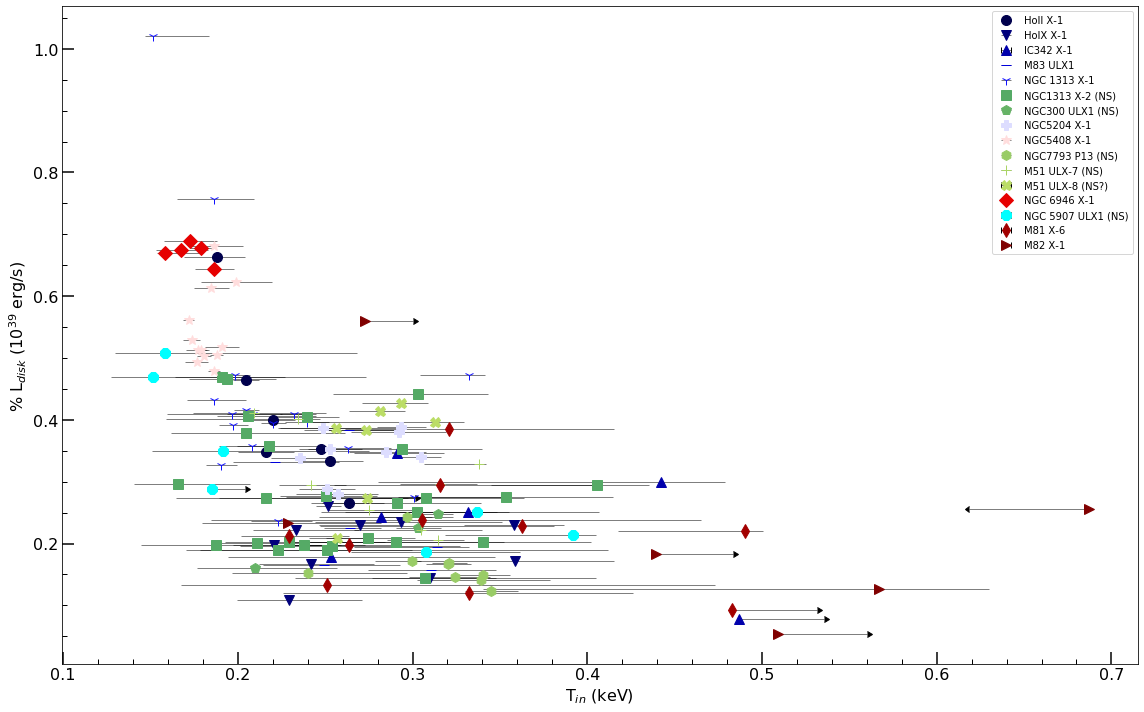

In [19]:
%matplotlib inline
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "seismic")
colors_ns = create_color_array(len(plot_config["source_dir"]), "summer")
markers = get_markers_array(len(plot_config["source_dir"]))
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    else:
        
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
    
    fluxes = read_flux_data("%s/fluxes/fluxes.dat" % source_dir)

    fluxes = np.array([flux for flux in fluxes if flux["xmm_obsid"] in data["xmm_obsid"]])
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
    disk_flux = data["%s" %param_2] * constant
    
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(disk_flux, 
                                                                                             data["%slow" %param_2]*constant, 
                                                                                             data["%supp" %param_2]*constant)
        

    
    if "(NS" in source_label:
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color
        
    plt.errorbar(data["%s" %param_1], disk_flux / (fluxes["03100"] * constant), 
                         xerr=[param_1err_low,  param_1err_high], 
                         label=source_label, color=current_color,
                         fmt=current_marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                         uplims=param_2uplimits, lolims=param_2lolimits, markersize=10, ecolor="black", 
                 elinewidth=0.5)


#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
#plt.yscale("log")
plt.xlabel("T$_{in}$ (keV)")
plt.ylabel("% L$_{disk}$ (10$^{39}$ erg/s)")

plt.legend()

## cutoffpl

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 16 datasets
Creating color array for 16 datasets


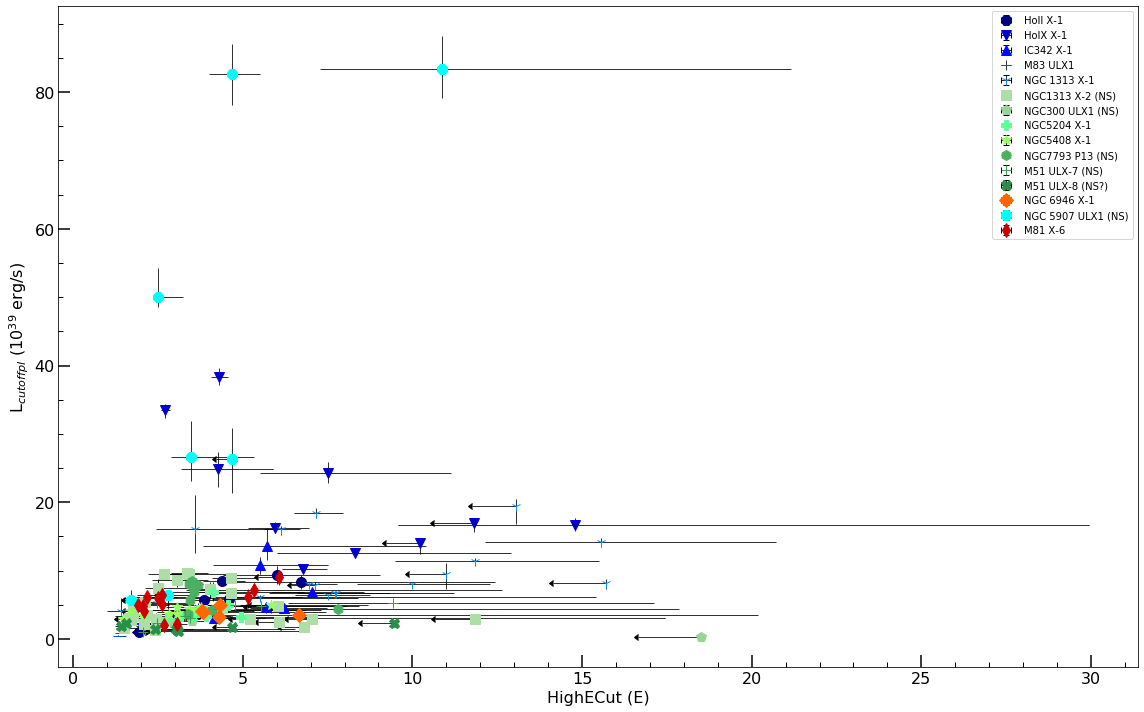

In [20]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile()
colors = create_color_array(len(plot_config["source_dir"]), "jet")
colors_ns = create_color_array(len(plot_config["source_dir"]), "Greens")
markers = get_markers_array(len(plot_config["source_dir"]))
#flux_ax.set_prop_cycle(cycler('color', colors))
annotate=0
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "HighECut"
param_2 = 'flux'
for source, source_label, model_dir, distance, color, color_ns, marker in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"], colors, colors_ns, markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!="M82X-1":
        
        data = read_comp_cutoffpl("%s/components/cutoffpl_0.dat" %source_dir)
    else:
        continue
        data = read_comp_cutoffpl("%s/components/chandra_cutoffpl_0.dat" %source_dir)
        
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
    disk_flux = data["%s" %param_2]*constant
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(disk_flux, 
                                                                                             data["%slow" %param_2]*constant, 
                                                                                             data["%supp" %param_2]*constant)
    
    if "(NS" in source_label:
        current_marker = marker
        if "NGC5907" in source:
            current_color="cyan"
        else:
            current_color=color_ns
    else:
        current_marker=marker
        current_color=color
        
    plt.errorbar(data["%s" %param_1], disk_flux, 
                         xerr=[param_1err_low,  param_1err_high], 
                         yerr=[param_2err_low, param_2err_high], 
                         label=source_label, color=current_color,
                         fmt=current_marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                         uplims=param_2uplimits, lolims=param_2lolimits, markersize=10, ecolor="black", 
                 elinewidth=0.8)


#plt.text(5,0.5,'L$_{EDD}$')
#plt.text(6,1.5,'10L$_{EDD}$')
#plt.text(7,10.5,'100L$_{EDD}$')
#plt.yscale("log")
plt.xlabel("%s (E)" %param_1)
plt.ylabel("L$_{cutoffpl}$ (10$^{39}$ erg/s)")

plt.legend()

## Lhard vs L mid

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")

hard_ax = flux_ax
hard_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance, color in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"], colors):
    
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        marker = 's'
        current_color=color
    else:
        marker='.'
        current_color=color
    hard_ax.errorbar(constant * data["50100"], constant * data["2050"] , 
                     xerr=[constant * (data["50100"] - data["lowerbound_2"]), 
                           constant * (data["upperbound_2"] - data["50100"])], 
                 yerr=[constant * (data["2050"]-data["lowerbound_1"]), 
                       constant * (data["upperbound_1"]-data["2050"])], 
                     label=source_label, fmt=marker, color=current_color)
#plot guiding line
hard_ax.plot(hard_ax.get_xlim(), hard_ax.get_ylim(), ls="--", c=".3")
#hard_ax.axhline(y=0.17)
hard_ax.set_ylabel("L [2 - 5 keV] (10$^{39}$) erg/s")
hard_ax.set_xlabel("L [5 - 10 keV] (10$^{39}$) erg/s")
plt.legend()

# L histogram

In [ ]:
%matplotlib qt
flux_time, histo_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")

histo_ax.set_prop_cycle(cycler('color', colors))

common_dir = "/home/agurpide/x_ray_data/"
bins=np.arange(0,100,1)
for source, source_label, distance, color in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"], colors):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        current_color="green"
    else:
        current_color=color
    l = data["03100"] * constant

    histo_ax.hist(l, bins=bins, color=current_color, alpha=0.6, label=source_label)
        
histo_ax.legend()

## PARAMS

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    if source=="NGC1313X-1":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
        param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                             data["%slow" %param_2], 
                                                                                             data["%supp" %param_2])
        
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        
        for index in np.arange(0, len(data["epoch"])):
            plt.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , 
                         xerr=[[param_1err_low[index]],  [param_1err_high[index]]], 
                         yerr=[[param_2err_low[index]], [param_2err_high[index]]], 
                         label=data["xmm_obsid"][index], 
                         fmt=marker, xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                         uplims=param_2uplimits[index], lolims=param_2lolimits[index])
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s/cm$^2$" %param_2)
plt.legend()

## TBABS VS TIME

In [ ]:
%matplotlib qt
tbabs_figure, tbabs_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"])-2, "jet")
tbabs_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"

param_1 = 'nH'
param_2 = "epoch"

for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    
    if source!="NGC1313X-1":
        continue
    else: 
        data = read_tbabs("%s/components/tbabs_1.dat" % source_dir)
    

    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
          
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
        
    tbabs_ax.errorbar(Time(data["epoch"]).jd, data["%s" %param_1] , yerr=[param_1err_low, param_1err_high],
                     label=source_label,uplims=param_1uplimits, lolims=param_1lolimits)

tbabs_ax.set_xlabel("Date")
tbabs_ax.set_ylabel("%s 10$^{22}$ cm$^{-2}$" % param_1)
date_formatter = FuncFormatter(jd_to_daymonthyear)
plt.xticks(rotation=45)
# save components flux plot
tbabs_ax.xaxis.set_major_formatter(date_formatter)
tbabs_ax.legend()

## Norm diskbb vs Time

In [ ]:
%matplotlib qt
tbabs_figure, tbabs_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"])-2, "jet")
tbabs_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"

param_1 = 'norm'
param_2 = "epoch"


for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    
    if source!="NGC1313X-1":
        continue
    else: 
        data = read_comp_diskbb("%s/components/diskbb_0.dat" % source_dir)
    
    print(data)
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
          
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
        
    tbabs_ax.errorbar(Time(data["epoch"]).jd, data["%s" %param_1] , yerr=[param_1err_low, param_1err_high],
                     label=source_label,uplims=param_1uplimits, lolims=param_1lolimits)

tbabs_ax.set_xlabel("Date")
tbabs_ax.set_ylabel("%s " % param_1)
date_formatter = FuncFormatter(jd_to_daymonthyear)
plt.xticks(rotation=45)
# save components flux plot
tbabs_ax.xaxis.set_major_formatter(date_formatter)
tbabs_ax.legend()

In [ ]:
%matplotlib qt
norm_norm, norm_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
norm_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    if source=="M81-X6":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
        data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
        ratio, ratio_err_low, ratio_err_high = compute_ratios(constant*data["50100"], 
                                                          constant*data["lowerbound_2"], 
                                                          data["upperbound_2"]* constant, 
                                                          data["0320"]* constant, 
                                                          data["lowerbound"]* constant, 
                                                      data["upperbound"]* constant)
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        for index in np.arange(0, len(data["epoch"])):
            norm_ax.errorbar(constant * data["03100"][index], ratio[index] , 
                             xerr=[[constant*(data["03100"][index]-data["lowerbound_3"][index])], 
                                   [constant*(data["upperbound_3"][index]-data["03100"][index])]], 
                             yerr=[[ratio_err_low[index]], [ratio_err_high[index]]], 
                             label=data["xmm_obsid"][index], fmt=marker)
norm_ax.set_xlabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
norm_ax.set_ylabel("L [5 - 10 keV] / L [0.2 - 3] erg/s")
plt.legend()

## NGC7793P13 vs M51-ULX7
## Pulsations vs HR

In [ ]:
%matplotlib qt
pulsations_hr, pulsations_hr_ax = plt.subplots(1, 1, figsize=(16, 10))
pulse_config = readbroadbandfile("pulsation_plots.config")
colors = create_color_array(len(pulse_config["source_dir"]), "tab20b")
markers = get_markers_array(len(pulse_config["source_dir"]))
pulsations_hr_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
pulsations_file = 'pulsations.txt'
for source, source_label, model_dir, distance, marker in zip(pulse_config["source_dir"], 
                                                              pulse_config["source_name"], 
                                                              pulse_config["model_dir"],
                                                              pulse_config["distance"], markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" % source_dir)
    pulsations = read_pulsations_file("%s/%s/%s" %(common_dir, source, pulsations_file))
    flux_data = np.array([flux for flux in flux_data if flux["xmm_obsid"] in pulsations["xmm_obsid"] or flux["chandra"] in pulsations["chandra"]])

    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((flux_data["2050"] + flux_data["50100"]), 
                                                  (flux_data["lowerbound_1"] + flux_data["lowerbound_2"]),
                                                                     (flux_data["upperbound_1"] + flux_data["upperbound_2"]) , 
                                                  flux_data["0320"], flux_data["lowerbound"],
                                                                     flux_data["upperbound"])
    
    for index in np.arange(0, len(pulsations["epoch"])):
        if pulsations["pulsations"][index]==0:
            color="red"                    
        else:
            color="green"
            
        plt.errorbar(ratio_soft[index], pulsations["PF"][index] , yerr=[[pulsations["err"][index]], 
                                                                           [pulsations["err"][index]]], 
                     xerr=[[ratio_err_low_soft[index]], [ratio_err_high_soft[index]]], 
                     label=source_label, color=color, 
                     fmt=marker, uplims=not pulsations["pulsations"][index], markersize=10)

remove_legend_repetitions(pulsations_hr_ax)
plt.ylabel("PF(%)")
plt.xlabel("F [2.0 - 10] / F [0.3 - 2.0]" )

## Pulsations vs L

In [ ]:
%matplotlib qt
pulsations_hr, pulsations_hr_ax = plt.subplots(1, 1, figsize=(16, 10))
pulse_config = readbroadbandfile("pulsation_plots.config")
colors = create_color_array(len(pulse_config["source_dir"]), "tab20b")
markers = get_markers_array(len(pulse_config["source_dir"]))
pulsations_hr_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
pulsations_file = 'pulsations.txt'
for source, source_label, model_dir, distance, marker in zip(pulse_config["source_dir"], 
                                                              pulse_config["source_name"], 
                                                              pulse_config["model_dir"],
                                                              pulse_config["distance"], markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    constant=1
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" % source_dir)
    pulsations = read_pulsations_file("%s/%s/%s" %(common_dir, source, pulsations_file))
    flux_data = np.array([flux for flux in flux_data if flux["xmm_obsid"] in pulsations["xmm_obsid"] or flux["chandra"] in pulsations["chandra"]])

    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((flux_data["2050"] + flux_data["50100"])* constant, 
                                                  (flux_data["lowerbound_1"] + flux_data["lowerbound_2"])* constant,
                                                                     (flux_data["upperbound_1"] + flux_data["upperbound_2"])* constant , 
                                                  constant*flux_data["0320"], constant*flux_data["lowerbound"],
                                                                     flux_data["upperbound"]* constant)
    
    for index in np.arange(0, len(pulsations["epoch"])):
        if pulsations["pulsations"][index]==0:
            color="red"                    
        else:
            color="green"
            
        plt.errorbar(pulsations["PF"][index], constant *flux_data["03100"][index] , xerr=[[pulsations["err"][index]], 
                                                                           [pulsations["err"][index]]], 
                     yerr=[[constant * (flux_data["03100"] - flux_data["lowerbound_3"])[index]], 
                       [constant * (flux_data["upperbound_3"]-flux_data["03100"])[index]]], 
                     label=source_label, color=color, 
                     fmt=marker, xuplims=not pulsations["pulsations"][index], markersize=10)

remove_legend_repetitions(pulsations_hr_ax)
plt.xlabel("PF(%)")
plt.ylabel("F [0.3 - 10] erg/s/cm$^2$" )

In [ ]:
## L vs HR vs P

In [ ]:
%matplotlib inline
pulsations_hr, pulsations_hr_ax = plt.subplots(1, 1, figsize=(16, 10))
pulse_config = readbroadbandfile("pulsation_plots.config")
colors = create_color_array(len(pulse_config["source_dir"]), "tab20b")
markers = get_markers_array(len(pulse_config["source_dir"]))
pulsations_hr_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
pulsations_file = 'pulsations.txt'
norm = plt.Normalize(0, 90)
for source, source_label, model_dir, distance, marker in zip(pulse_config["source_dir"], 
                                                              pulse_config["source_name"], 
                                                              pulse_config["model_dir"],
                                                              pulse_config["distance"], markers):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    constant=1

    
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" % source_dir)
    pulsations = read_pulsations_file("%s/%s/%s" %(common_dir, source, pulsations_file))
    flux_data = np.array([flux for flux in flux_data if flux["xmm_obsid"] in pulsations["xmm_obsid"] 
                          or (flux["chandra"] in pulsations["chandra"] and flux["chandra"]!="")])
    
    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((flux_data["2050"] + flux_data["50100"]) * constant, 
                                                  (flux_data["lowerbound_1"] + flux_data["lowerbound_2"]) * constant,
                                                                     (flux_data["upperbound_1"] + flux_data["upperbound_2"])* constant , 
                                                  constant*flux_data["0320"], constant*flux_data["lowerbound"],
                                                                     flux_data["upperbound"]* constant)
    
    for index in np.arange(0, len(pulsations["epoch"])):
        indexes_pulsations = np.where(pulsations["pulsations"][index]==1)
        indexes_nopulsations = np.where(pulsations["pulsations"][index]==0)
        if pulsations["pulsations"][index]==0:
            color="red"                    
        else:
            color="green"
        print("")
        '''  
        plt.errorbar(ratio_soft[index], constant *flux_data["03100"][index] , xerr=[[ratio_err_low_soft[index]], 
                                                                                    [ratio_err_high_soft[index]]], 
                     yerr=[[constant * (flux_data["03100"] - flux_data["lowerbound_3"])[index]], 
                       [constant * (flux_data["upperbound_3"]-flux_data["03100"])[index]]], 
                     label=source_label, color=color, 
                     fmt=marker, xuplims=not pulsations["pulsations"][index])
        '''
    indexes_pulsations = np.where(pulsations["pulsations"]==1)
    ratio_soft_pulsations = ratio_soft[indexes_pulsations]
    total_fluxes_yes = flux_data["03100"][indexes_pulsations]
    pulsations_yes = pulsations["PF"][indexes_pulsations]
    print(total_fluxes_yes)
    scatter_yes = pulsations_hr_ax.scatter(ratio_soft_pulsations, total_fluxes_yes, c=pulsations_yes, label=source_label, s=50,
                marker=marker, norm=norm, cmap='jet')
    indexes_pulsations = np.where(pulsations["pulsations"]==0)
    ratio_soft_pulsations = ratio_soft[indexes_pulsations]
    total_fluxes_yes = flux_data["03100"][indexes_pulsations]
    pulsations_yes = pulsations["PF"][indexes_pulsations]
    print(total_fluxes_yes)
    if len(total_fluxes_yes)!=0:
        scatter_no = pulsations_hr_ax.scatter(ratio_soft_pulsations, total_fluxes_yes, c=pulsations_yes, label=source_label, s=50,
               marker=marker, norm=norm, cmap='viridis', alpha=0.3)
    for i in np.arange(1, len(flux_data["03100"])):
        plt.annotate("", xy=(ratio_soft[i-1],flux_data["03100"][i-1]), xytext=(ratio_soft[i], flux_data["03100"][i]),
                     arrowprops=dict(arrowstyle="<-", shrinkA=10, shrinkB=10, color="black"))      
plt.colorbar(scatter_yes, label="PF (%)")
plt.colorbar(scatter_no, label="Upp PF (%)")
pulsations_hr_ax.set_ylim(1e-14, 1e-11)
#remove_legend_repetitions(pulsations_hr_ax)
plt.xlabel("F [2.0 - 10] / F [0.3 - 2.0]")
plt.ylabel("F [0.3 - 10] erg/s/cm$^2$" )

## M51 ULX-7

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    if source=="M51-ULX7":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
        param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                             data["%slow" %param_2], 
                                                                                             data["%supp" %param_2])
        
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        
        for index in np.arange(0, len(data["epoch"])):
            plt.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , xerr=[[param_1err_low[index]], 
                                                                               [param_1err_high[index]]], 
                         yerr=[[param_2err_low[index]], [param_2err_high[index]]], 
                         label=data["xmm_obsid"][index], 
                         fmt=marker, xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                         uplims=param_2uplimits[index], lolims=param_2lolimits[index])
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s/cm$^2$" %param_2)
plt.legend()

## Any source

In [174]:
plot_source="IC342"

In [176]:
%matplotlib qt
flux_time, diskbb_T_ax = plt.subplots(1, 1, figsize=(16, 10))
plot_config = readbroadbandfile(file="broadband_fitting_plot.config")

common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    if source==plot_source:
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
        if source=="M82X-1":
            data = read_comp_diskbb("%s/components/chandra_diskbb_1.dat" %source_dir)
        else:
            data = read_comp_diskbb("%s/components/diskbb_1.dat" %source_dir)
        colors = create_color_array(len(data["epoch"]), "jet")
        markers = get_markers_array(len(data["epoch"]))
        diskbb_T_ax.set_prop_cycle(cycler('color', colors))
        param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                             data["%slow" %param_2], 
                                                                                             data["%supp" %param_2])
        
        for index in np.arange(0, len(data["epoch"])):
            if data["xmm_obsid"][index]!="":
                label=data["xmm_obsid"][index]
            else:
                label=data["chandra"][index]
            print(label)
            diskbb_T_ax.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , 
                                 xerr=[[param_1err_low[index]], [param_1err_high[index]]], 
                                 yerr=[[param_2err_low[index]], [param_2err_high[index]]], label=label, 
                                 fmt=markers[index], xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                                 uplims=param_2uplimits[index], lolims=param_2lolimits[index], markersize=10)
            print("Mass (M) for obs %s: %.2f" %(label,disknorm_tomass(data["norm"][index], distance, angle=80)))
        draw_arrows(data["%s" %param_1], data["%s" %param_2], colors)
        if param_1=="Tin":
            a,b,  a_err, b_err = fit_diskbb(data["%s" %param_2], data["%s" %param_1], param_1err_low, param_1err_high)
            print("%.1f $\pm$ %.2f" % (b, b_err))
        
            data.sort(order='Tin')
            plt.plot(data["%s" %param_1], diskLvsT(data["%s" %param_1],a ,b), color="black", marker=None, ls='--')
        
plt.yscale("log")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s/cm$^2$" %param_2)
plt.legend()

[('source_dir', '<U13'), ('model_dir', '<U17'), ('source_name', '<U18'), ('distance', '<f8')]
Creating color array for 6 datasets
0093640901
Mass (M) for obs 0093640901: 6.96
0206890101
Mass (M) for obs 0206890101: 19.92
0206890201
Mass (M) for obs 0206890201: 7.97
0206890401
Mass (M) for obs 0206890401: 20.26
0693850601
Mass (M) for obs 0693850601: 19.23
0693851301
Mass (M) for obs 0693851301: 26.16
-0.5 $\pm$ 1.09


## Flux diskbb vs T

## Cutoff vs L

Creating color array for 6 datasets


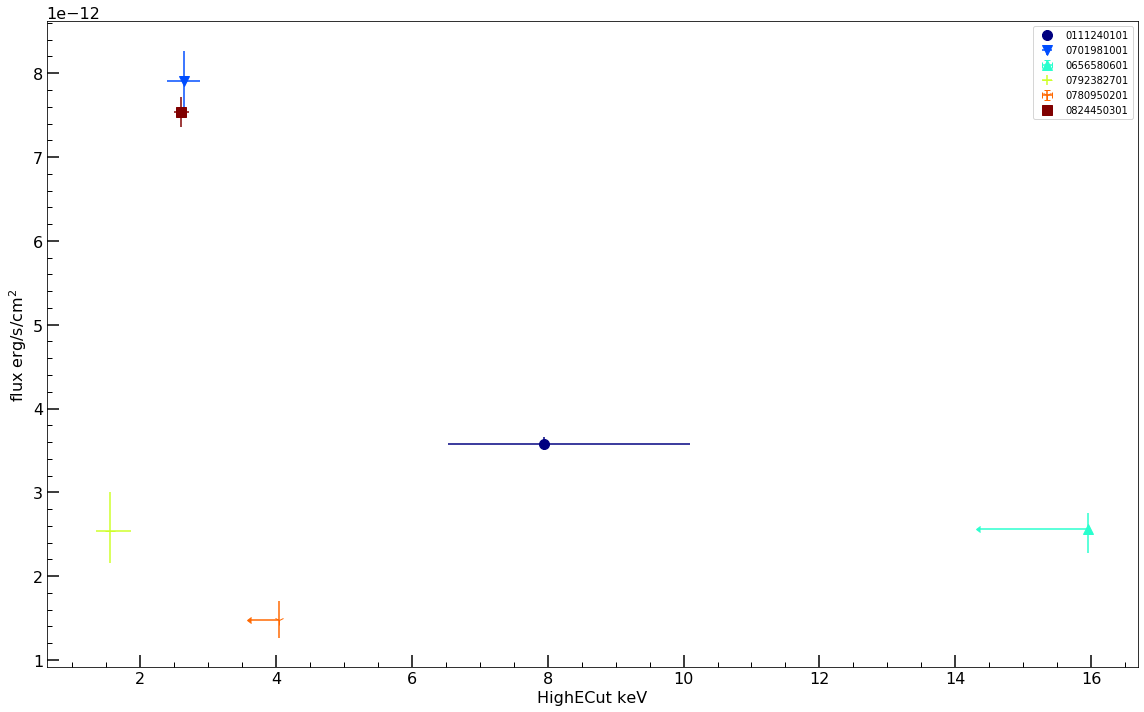

In [34]:
%matplotlib inline
flux_time, diskbb_T_ax = plt.subplots(1, 1, figsize=(16, 10))


common_dir = "/home/agurpide/x_ray_data/"
param_1 = "HighECut"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    if source==plot_source:
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
        data = read_comp_cutoffpl("%s/components/cutoffpl_0.dat" %source_dir)
        colors = create_color_array(len(data["epoch"]), "jet")
        markers = get_markers_array(len(data["epoch"]))
        diskbb_T_ax.set_prop_cycle(cycler('color', colors))
        param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                             data["%slow" %param_2], 
                                                                                             data["%supp" %param_2])

        for index in np.arange(0, len(data["epoch"])):
            diskbb_T_ax.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , xerr=[[param_1err_low[index]], 
                                                                               [param_1err_high[index]]], 
                         yerr=[[param_2err_low[index]], [param_2err_high[index]]], 
                         label=data["xmm_obsid"][index], 
                         fmt=markers[index], xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                         uplims=param_2uplimits[index], lolims=param_2lolimits[index], markersize=10)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s/cm$^2$" %param_2)
plt.legend()

## HID 

In [133]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))


annotate=1
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!=plot_source:
        continue
    data = read_flux_data("%s/fluxes/fluxes.dat" % source_dir)
    colors = create_color_array(len(data["epoch"]), "jet")
    markers = get_markers_array(len(data["epoch"]))
    flux_ax.set_prop_cycle(cycler('color', colors))
    ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((data["2050"] + data["50100"])* constant, 
                                                      (data["lowerbound_1"] + data["lowerbound_2"])* constant,
                                                                         (data["upperbound_1"] + data["upperbound_2"])* constant , 
                                                      constant*data["0320"], constant*data["lowerbound"],
                                                                         data["upperbound"]* constant)
    print(constant * data["03100"])
    for index in np.arange(0, len(data["epoch"])):
        if data["xmm_obsid"][index]!="":
            label=data["xmm_obsid"][index]
        else:
            label=data["chandra"][index]
        plt.errorbar(ratio_soft[index], constant * data["03100"][index], 
                 yerr=[[constant * (data["03100"] - data["lowerbound_3"])[index]], 
                       [constant * (data["upperbound_3"]-data["03100"])[index]]], 
                 xerr=[[ratio_err_low_soft[index]], [ratio_err_high_soft[index]]], label=label,
                 fmt=markers[index], markersize=10)
    draw_arrows(ratio_soft, constant * data["03100"], colors)

plt.axhline(y=0.16, ls='--', color='grey')
#plt.text(5,0.5,'L$_{EDD}$')
plt.axhline(y=1.16, ls='--', color='grey')
#plt.text(6,1.5,'10L$_{EDD}$')
plt.axhline(y=10.16, ls='--', color='grey')
#plt.text(7,10.5,'100L$_{EDD}$')
plt.ylabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
plt.xlabel("L [2 - 10 keV] / L [0.3 - 2 keV]")

plt.legend()

Creating color array for 8 datasets
[10.23308213 10.70055885  3.15359893 11.55597144 12.60684635  4.54262053
  8.86964953  8.21308769]


## tbabs vs time

In [40]:
tbabs_figure, tbabs_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"])-2, "jet")
tbabs_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"

param_1 = 'nH'
param_2 = "epoch"

for source, source_label, model_dir, distance in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"], 
                                                     plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source!=plot_source:
        continue
    else: 
        data = read_tbabs("%s/components/tbabs_1.dat" % source_dir)
    

    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
          
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
        
    tbabs_ax.errorbar(Time(data["epoch"]).jd, data["%s" %param_1] , yerr=[param_1err_low, param_1err_high],
                     label=source_label,uplims=param_1uplimits, lolims=param_1lolimits)

tbabs_ax.set_xlabel("Date")
tbabs_ax.set_ylabel("%s 10$^{22}$ cm$^{-2}$" % param_1)
date_formatter = FuncFormatter(jd_to_daymonthyear)
plt.xticks(rotation=45)
# save components flux plot
tbabs_ax.xaxis.set_major_formatter(date_formatter)
tbabs_ax.legend()

Creating color array for 15 datasets


AxisError: axis -1 is out of bounds for array of dimension 0

## Time vs L

In [ ]:
%matplotlib qt
fluxes_time_fig, fluxes_ax = plt.subplots(1,3, figsize=(16.0, 14.0), gridspec_kw={'hspace': 0, 'wspace': 0}, 
                                          sharey=True)
colors = create_color_array(len(plot_config["source_dir"]), "jet")

hard_ax = fluxes_ax[2]
mid_ax = fluxes_ax[1]
soft_ax = fluxes_ax[0]
hard_ax.set_prop_cycle(cycler('color', colors))
mid_ax.set_prop_cycle(cycler('color', colors))
soft_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        marker = 's'
        current_color=color
    else:
        marker='.'
        current_color=color
    soft_ax.errorbar(data["epoch"],  data["0320"] / data["03100"],  
                     label=source_label, color=current_color)
    mid_ax.errorbar(data["epoch"], data["2050"] / data["03100"] , 
                     label=source_label, color=current_color)
    hard_ax.errorbar(data["epoch"], data["50100"] / data["03100"], 
                     label=source_label, color=current_color)
date_formatter = FuncFormatter(jd_to_daymonthyear)

# save components flux plot
soft_ax.xaxis.set_major_formatter(date_formatter)
#hard_ax.axhline(y=0.17)
hard_ax.set_ylabel("L [5 - 10 keV] (10$^{39}$) erg/s")
soft_ax.set_ylabel("L [0.3 - 2 keV] (10$^{39}$) erg/s")
mid_ax.set_ylabel("L [2 - 5 keV] (10$^{39}$) erg/s")
soft_ax.set_xlabel("Time (date)")
plt.legend()

## M82 X-1

In [ ]:
%matplotlib qt
broadband_file = "/home/agurpide/x_ray_data/broadband_fitting_plot.config"
plot_config = np.genfromtxt(broadband_file, delimiter="\t\t", dtype=("U13", "U17", "U18", float), names=True)

print(plot_config.dtype)
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["model_dir"], plot_config["distance"]):
    if source=="M82X-1":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        print(model_dir)
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
        param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                             data["%slow" %param_2], 
                                                                                             data["%supp" %param_2])
        
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        
        for index in np.arange(0, len(data["epoch"])):
            plt.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , xerr=[[param_1err_low[index]], 
                                                                               [param_1err_high[index]]], 
                         yerr=[[param_2err_low[index]], [param_2err_high[index]]], 
                         label=data["chandra"][index], 
                         fmt=marker, xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                         uplims=param_2uplimits[index], lolims=param_2lolimits[index])
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s/cm$^2$" %param_2)
plt.legend()

## tbabs Holmberg II X-1 vs IC 342 X-1

In [ ]:
%matplotlib qt
tbabs_figure, tbabs_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"])-2, "jet")
tbabs_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"

param_1 = 'nH'
param_2 = "epoch"

for source, source_label, model_dir, distance in zip(plot_config["source_dir"], 
                                                     plot_config["source_name"], 
                                                     plot_config["model_dir"],
                                                                 plot_config["distance"]):
    
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source=="NGC55":
        continue
    if source=="M82X-1":
        continue
    else: 
        data = read_tbabs("%s/components/tbabs_1.dat" % source_dir)
    

    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
          
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
        
    tbabs_ax.errorbar(Time(data["epoch"]).jd, data["%s" %param_1] , yerr=[param_1err_low, param_1err_high],
                     label=source_label,uplims=param_1uplimits, lolims=param_1lolimits)

tbabs_ax.set_xlabel("Date")
tbabs_ax.set_ylabel("%s 10$^{22}$ cm$^{-2}$" % param_1)
date_formatter = FuncFormatter(jd_to_daymonthyear)
plt.xticks(rotation=45)
# save components flux plot
tbabs_ax.xaxis.set_major_formatter(date_formatter)
tbabs_ax.legend()

## NGC 7793 P13 flux change?

In [ ]:
%matplotlib qt
norm_norm, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
flux_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    if source=="NGC7793P13":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        compTT_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
        double_diskbb_dir = "%s/%s/diskbbcutoffpl" %(common_dir, source)
        compTT_data = read_flux_data("%s/fluxes/fluxes.dat" %compTT_dir)
        double_diskbb_data = read_flux_data("%s/fluxes/fluxes.dat" %double_diskbb_dir)
        
    
        ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((compTT_data["2050"] + compTT_data["50100"])* constant, 
                                                      (compTT_data["lowerbound_1"] + compTT_data["lowerbound_2"])* constant,
                                                                         (compTT_data["upperbound_1"] + compTT_data["upperbound_2"])* constant , 
                                                      constant*compTT_data["0320"], constant*compTT_data["lowerbound"],
                                                                         compTT_data["upperbound"]* constant)
        
            
        ratio_soft_dd, ratio_err_low_soft_dd, ratio_err_high_soft_dd = compute_ratios((double_diskbb_data["2050"] + double_diskbb_data["50100"])* constant, 
                                                      (double_diskbb_data["lowerbound_1"] + double_diskbb_data["lowerbound_2"])* constant,
                                                                         (compTT_data["upperbound_1"] + compTT_data["upperbound_2"])* constant , 
                                                      constant*double_diskbb_data["0320"], constant*double_diskbb_data["lowerbound"],
                                                                         compTT_data["upperbound"]* constant)
        
        
        
        err_flux_low, err_flux_high,lolims,  uplims = bounds_to_errors(compTT_data["03100"], compTT_data["lowerbound_3"], compTT_data["upperbound_3"])
        err_flux_low_dd, err_flux_high_dd,lolims_dd,  uplims_dd = bounds_to_errors(double_diskbb_data["03100"],
                                                                                   double_diskbb_data["lowerbound_3"],
                                                                                   double_diskbb_data["upperbound_3"])
        
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        for index in np.arange(0, len(compTT_data["epoch"])):
            flux_ax.errorbar(constant * compTT_data["03100"][index], ratio_soft[index], 
                             xerr=[[constant*(err_flux_low[index])], 
                                   [constant*(err_flux_high[index])]], 
                             yerr=[[ratio_err_low_soft[index]], [ratio_err_high_soft[index]]],
                             xlolims=lolims[index], xuplims=uplims[index],
                             label=compTT_data["xmm_obsid"][index], fmt=marker, color='blue')
            
            flux_ax.errorbar(constant * double_diskbb_data["03100"][index], ratio_soft_dd[index], 
                             xerr=[[constant*(err_flux_low_dd[index])], 
                                   [constant*(err_flux_high_dd[index])]], 
                             yerr=[[ratio_err_low_soft_dd[index]], [ratio_err_high_soft_dd[index]]],
                             xlolims=lolims_dd[index], xuplims=uplims_dd[index], fmt=".", color='green')
            
flux_ax.set_xlabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
flux_ax.set_ylabel("L [2 - 10 keV] / L [0.3 - 2] erg/s")
#plt.legend()

## NGC 5907 flux change?

In [ ]:
%matplotlib qt
norm_norm, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
flux_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    if source=="NGC5907":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        compTT_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
        onlycomptt_dir = "%s/%s/compTT" %(common_dir, source)
        compTT_data = read_flux_data("%s/fluxes/fluxes.dat" %compTT_dir)
        only_comptt_data = read_flux_data("%s/fluxes/fluxes.dat" %onlycomptt_dir)
        
    
        ratio_soft, ratio_err_low_soft, ratio_err_high_soft = compute_ratios((compTT_data["2050"] + compTT_data["50100"])* constant, 
                                                      (compTT_data["lowerbound_1"] + compTT_data["lowerbound_2"])* constant,
                                                                         (compTT_data["upperbound_1"] + compTT_data["upperbound_2"])* constant , 
                                                      constant*compTT_data["0320"], constant*compTT_data["lowerbound"],
                                                                         compTT_data["upperbound"]* constant)
        
            
        ratio_soft_dd, ratio_err_low_soft_dd, ratio_err_high_soft_dd = compute_ratios((only_comptt_data["2050"] + only_comptt_data["50100"])* constant, 
                                                      (only_comptt_data["lowerbound_1"] + only_comptt_data["lowerbound_2"])* constant,
                                                                         (compTT_data["upperbound_1"] + compTT_data["upperbound_2"])* constant , 
                                                      constant*only_comptt_data["0320"], constant*only_comptt_data["lowerbound"],
                                                                         compTT_data["upperbound"]* constant)
        
        
        
        err_flux_low, err_flux_high,lolims,  uplims = bounds_to_errors(compTT_data["03100"], compTT_data["lowerbound_3"], compTT_data["upperbound_3"])
        err_flux_low_dd, err_flux_high_dd,lolims_dd,  uplims_dd = bounds_to_errors(only_comptt_data["03100"],
                                                                                   only_comptt_data["lowerbound_3"],
                                                                                   only_comptt_data["upperbound_3"])
        
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        for index in np.arange(0, len(compTT_data["epoch"])):
            flux_ax.errorbar(ratio_soft[index],constant * compTT_data["03100"][index], 
                             yerr=[[constant*(err_flux_low[index])], 
                                   [constant*(err_flux_high[index])]], 
                             xerr=[[ratio_err_low_soft[index]], [ratio_err_high_soft[index]]],
                             lolims=lolims[index], uplims=uplims[index],
                             label=compTT_data["xmm_obsid"][index], fmt=marker, color='blue')
            
            flux_ax.errorbar(ratio_soft_dd[index],constant * only_comptt_data["03100"][index], 
                             yerr=[[constant*(err_flux_low_dd[index])], 
                                   [constant*(err_flux_high_dd[index])]], 
                             xerr=[[ratio_err_low_soft_dd[index]], [ratio_err_high_soft_dd[index]]],
                             lolims=lolims_dd[index], uplims=uplims_dd[index], fmt=".", color='green')
plt.axhline(y=0.16, ls='--', color='grey')
#plt.text(5,0.5,'L$_{EDD}$')
plt.axhline(y=1.16, ls='--', color='grey')
#plt.text(6,1.5,'10L$_{EDD}$')
plt.axhline(y=10.16, ls='--', color='grey')
#plt.text(7,10.5,'100L$_{EDD}$')            
flux_ax.set_ylabel("L [0.3 - 10 keV] (10$^{39}$) erg/s")
flux_ax.set_xlabel("L [2 - 10 keV] / L [0.3 - 2] erg/s")
plt.legend()

## Holmberg IX X-1 vs M82 X-1 vs NGC5408X-1 vs NGC1313X-1 vs NGC6946X-1

In [ ]:
%matplotlib qt
fluxes_time_fig, fluxes_ax = plt.subplots(3,1, figsize=(16.0, 14.0), gridspec_kw={'hspace': 0, 'wspace': 0}, 
                                          sharey=True)
colors = create_color_array(len(plot_config["source_dir"]), "jet")

hard_ax = fluxes_ax[2]
mid_ax = fluxes_ax[1]
soft_ax = fluxes_ax[0]
hard_ax.set_prop_cycle(cycler('color', colors))
mid_ax.set_prop_cycle(cycler('color', colors))
soft_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, model_dir, distance, color in zip(plot_config["source_dir"], 
                                                            plot_config["source_name"],
                                                            plot_config["model_dir"],
                                                            plot_config["distance"], colors):
    if source!="holmbergX9" and source!="M82X-1" and source!="NGC1313X-1" and source!="NGC5408X-1" and source!="NGC6946X-1":
        continue
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = (4 * m.pi * distancecm ** 2) / 10** 39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    if "(P)" in source_label:
        marker = 's'
        current_color=color
    else:
        marker='.'
        current_color=color
    error_low, error_high, lolimit, uplimit = bounds_to_errors(data["2050"], data["lowerbound_1"], data["upperbound_1"])
    soft_ax.errorbar(data["epoch"] - data["epoch"][0],  data["0320"] / data["03100"],  
                     label=source_label, color=current_color, fmt='.', linestyle='solid')
    mid_ax.errorbar(data["epoch"]- data["epoch"][0], data["2050"] / data["03100"] , 
                     label=source_label, color=current_color, fmt='.', linestyle='solid',
                   xerr=[error_low,error_high], xuplims=uplimit, xlolims=lolimit )
    hard_ax.errorbar(data["epoch"]- data["epoch"][0], data["50100"] / data["03100"], 
                     label=source_label, color=current_color, fmt='.', linestyle='solid')

date_formatter = FuncFormatter(jd_to_daymonthyear)

# save components flux plot
#hard_ax.axhline(y=0.17)
hard_ax.set_ylabel("L [5 - 10 keV] / L$_{tot}$")
soft_ax.set_ylabel("L [0.3 - 2 keV] / L$_{tot}$")
mid_ax.set_ylabel("L [2 - 5 keV] / L$_{tot}$")
soft_ax.set_xlabel("Time (date)")
plt.legend()

In [ ]:
%matplotlib qt
diskbb_figure, diskflux_t = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(5, "jet")
diskflux_t.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], 
                                          plot_config["source_name"],
                                          plot_config["model_dir"],
                                          plot_config["distance"]):
    if source!="holmbergIIX1" and source!="holmbergX9" and source!="M82X-1" and source!="NGC1313X-1" and source!="NGC5408X-1" and source!="NGC6946X-1":
        continue
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source=="M82X-1":
        
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
         
    else:
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    flux_data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
    flux_data = flux_data[np.where(flux_data["chandra"]=="")]
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                         data["%slow" %param_1], 
                                                                                         data["%supp" %param_1])
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2]*constant, 
                                                                                         data["%slow" %param_2]*constant, 
                                                                                         data["%supp" %param_2]*constant)

    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'

    plt.errorbar(data["%s" %param_1], data["%s" %param_2] * constant , xerr=[param_1err_low, param_1err_high], 
                yerr=[param_2err_low, param_2err_high], label=source_label, fmt=marker, 
               xlolims=param_1lolimits, xuplims=param_1uplimits, uplims=param_2uplimits, lolims=param_2lolimits)
    scatter = diskflux_t.scatter(data["%s" %param_1], data["%s" %param_2] * constant, flux_data["03100"]*constant)
    #colorbar = diskbb_figure.colorbar(scatter, ax=diskflux_t)
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s (keV)" %param_1)
plt.ylabel("L (10$^{39}$) erg/s" )
plt.legend()

## NGC5907 ULX1

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    if source=="NGC5907":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        constant = 1
        source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
        param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                             data["%slow" %param_1], 
                                                                                             data["%supp" %param_1])
        param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2], 
                                                                                             data["%slow" %param_2], 
                                                                                             data["%supp" %param_2])
        
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        
        for index in np.arange(0, len(data["epoch"])):
            plt.errorbar(data["%s" %param_1][index], data["%s" %param_2][index] , xerr=[[param_1err_low[index]], 
                                                                               [param_1err_high[index]]], 
                         yerr=[[param_2err_low[index]], [param_2err_high[index]]], 
                         label=data["xmm_obsid"][index], 
                         fmt=marker, xlolims=param_1lolimits[index], xuplims=param_1uplimits[index], 
                         uplims=param_2uplimits[index], lolims=param_2lolimits[index])
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s/cm$^2$" %param_2)
plt.legend()

In [ ]:
%matplotlib qt
norm_norm, norm_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "tab20b")
norm_ax.set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
for source, source_label, distance in zip(plot_config["source_dir"], plot_config["source_name"], plot_config["distance"]):
    if source=="NGC5907":
        parsecs = distance * m.pow(10, 6)
        # parsecs to cm
        distancecm = u.pc.to(u.cm, parsecs)
        constant = 4 * m.pi * distancecm ** 2 / 10**39
        source_dir = "%s/%s/diskbbcompTT" %(common_dir, source)
        data = read_flux_data("%s/fluxes/fluxes.dat" %source_dir)
        ratio, ratio_err_low, ratio_err_high = compute_ratios(constant*data["50100"], 
                                                          constant*data["lowerbound_2"], 
                                                          data["upperbound_2"]* constant, 
                                                          data["0320"]* constant, 
                                                          data["lowerbound"]* constant, 
                                                      data["upperbound"]* constant)
        if "(P)" in source_label:
            marker = 's'
        else:
            marker='.'
        for index in np.arange(0, len(data["epoch"])):
            norm_ax.errorbar(ratio[index]  , constant * data["03100"][index],  
                             yerr=[[constant*(data["03100"][index]-data["lowerbound_3"][index])], 
                                   [constant*(data["upperbound_3"][index]-data["03100"][index])]], 
                             xerr=[[ratio_err_low[index]], [ratio_err_high[index]]], 
                             label=data["xmm_obsid"][index], fmt=marker)
norm_ax.set_xlabel("[5 - 10 keV] / L [0.2 - 3]")
norm_ax.set_ylabel("Flux  erg/s/cm$^2$")
plt.axhline(y=0.16, ls='--', color='grey')
plt.text(5,0.5,'L$_{EDD}$')
plt.axhline(y=1.16, ls='--', color='grey')
plt.text(6,1.5,'10L$_{EDD}$')
plt.axhline(y=10.16, ls='--', color='grey')
plt.text(7,10.5,'100L$_{EDD}$')
plt.legend()

## ALL diskbb vs flux

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "Tin"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], 
                                          plot_config["model_dir"],
                                          plot_config["distance"]):
    if source=="NGC55" or source=="NGC5907":
        continue
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source=="M82X-1":
        continue
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
    else:
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                         data["%slow" %param_1], 
                                                                                         data["%supp" %param_1])
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2]*constant, 
                                                                                         data["%slow" %param_2]*constant, 
                                                                                         data["%supp" %param_2]*constant)
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
    
    plt.errorbar(data["%s" %param_1], data["%s" %param_2]*constant, xerr=[param_1err_low, param_1err_high], 
                     yerr=[param_2err_low, param_2err_high], 
                     fmt=marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                     uplims=param_2uplimits, lolims=param_2lolimits, label=source_label)
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s" %param_2)
plt.legend()

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "norm"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], 
                                          plot_config["model_dir"],
                                          plot_config["distance"]):
    if source=="NGC55" or source=="NGC5907":
        continue
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source=="M82X-1":
        data = read_comp_diskbb("%s/components/chandra_diskbb_0.dat" %source_dir)
    else:
        data = read_comp_diskbb("%s/components/diskbb_0.dat" %source_dir)
    
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                         data["%slow" %param_1], 
                                                                                         data["%supp" %param_1])
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2]*constant, 
                                                                                         data["%slow" %param_2]*constant, 
                                                                                         data["%supp" %param_2]*constant)
    if "(P)" in source_label:
        marker = 's'
    else:
        marker='.'
    
    plt.errorbar(data["%s" %param_1], data["%s" %param_2]*constant, xerr=[param_1err_low, param_1err_high], 
                     yerr=[param_2err_low, param_2err_high], 
                     fmt=marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                     uplims=param_2uplimits, lolims=param_2lolimits, label=source_label)
t = np.arange(np.min(data["Tin"]), np.max(data["Tin"]), 0.01)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s" %param_2)
plt.legend()

In [ ]:
%matplotlib qt
flux_time, flux_ax = plt.subplots(1, 1, figsize=(16, 10))

colors = create_color_array(len(plot_config["source_dir"]), "jet")
plt.gca().set_prop_cycle(cycler('color', colors))
common_dir = "/home/agurpide/x_ray_data/"
param_1 = "norm"
param_2 = 'flux'
for source, source_label, model_dir, distance in zip(plot_config["source_dir"], plot_config["source_name"], 
                                          plot_config["model_dir"],
                                          plot_config["distance"]):
    if source=="NGC55" or source=="NGC5907":
        continue
    parsecs = distance * m.pow(10, 6)
    # parsecs to cm
    distancecm = u.pc.to(u.cm, parsecs)
    constant = 4 * m.pi * distancecm ** 2 / 10**39
    
    source_dir = "%s/%s/%s" %(common_dir, source, model_dir)
    if source=="M82X-1":
        data = read_comp_compTT("%s/components/chandra_compTT_0.dat" %source_dir)
    else:
        data = read_comp_compTT("%s/components/compTT_0.dat" %source_dir)
    param_1err_low, param_1err_high, param_1lolimits, param_1uplimits = bounds_to_errors(data["%s" %param_1], 
                                                                                         data["%slow" %param_1], 
                                                                                         data["%supp" %param_1])
    param_2err_low, param_2err_high, param_2lolimits, param_2uplimits = bounds_to_errors(data["%s" %param_2]*constant, 
                                                                                         data["%slow" %param_2]*constant, 
                                                                                         data["%supp" %param_2]*constant)
    if "(NS" in source_label:
        marker = 's'
    else:
        marker='.'
    
    plt.errorbar(data["%s" %param_1], data["%s" %param_2]*constant, xerr=[param_1err_low, param_1err_high], 
                     yerr=[param_2err_low, param_2err_high], 
                     fmt=marker, xlolims=param_1lolimits, xuplims=param_1uplimits, 
                     uplims=param_2uplimits, lolims=param_2lolimits, label=source_label)
#plt.plot(t, 10*np.max(data["flux"])*t**4, ls='--', color="black")
plt.xlabel("%s keV" %param_1)
plt.ylabel("%s erg/s" %param_2)
plt.legend()